### Canal Phase FLIP NÃO MARKOVIANO

In [1]:
from sympy import *
import numpy as np

init_printing(use_unicode=True)
from matplotlib import pyplot as plt
%matplotlib inline
from sympy.physics.quantum.dagger import Dagger
from sympy.physics.quantum import TensorProduct
import scipy.interpolate
import platform

In [2]:
def cb(d, j):
    cbs = zeros(d,1); cbs[j] = 1
    return cbs
def proj(psi):
    return psi*Dagger(psi)

def coh_l1(rho):
    d = rho.shape[0]; C = 0
    for j in range(0,d-1):
        for k in range(j+1,d):
            C += abs(rho[j,k])
    return 2*C

def Pauli(j):
    if j == 0:
        return Matrix([[1,0],[0,1]])
    elif j == 1:
        return Matrix([[0,1],[1,0]])
    elif j == 2:
        return Matrix([[0,-1j],[1j,0]])
    elif j == 3:
        return Matrix([[1,0],[0,-1]])

In [69]:
#from noMarkov.tools import EoF
'''   ENTROPY.PY                 '''
import math
import scipy.linalg.lapack as lapak
import sys
sys.path.append('..')
import src.pTrace

def purity(rho):
    d = rho.shape[0]
    purity = 0.0
    j = -1
    while (j < d-1):
        j = j + 1
        k = -1
        while (k < d-1):
            k = k + 1
            purity += (rho[j][k].real)**2 + (rho[j][k].imag)**2
    return purity

def linear_entropy(rho):
    return 1-purity(rho)

def shannon(pv):
    d = pv.shape[0]
    SE = 0.0
    j = -1
    while (j < d-1):
        j = j + 1
        if pv[j] > 1.e-15 and pv[j] < (1.0-1.e-15):
            SE -= pv[j]*math.log(pv[j], 2)
    return SE

def von_neumann(rho):
    d = rho.shape[0]
    b = lapak.zheevd(rho)
    VnE = shannon(b[0])
    return VnE

def mutual_info(rho, dl, dr):
    rhor = pTrace.pTraceL(dl, dr, rho)
    rhol = pTrace.pTraceR(dl, dr, rho)
    return von_neumann(rhol) + von_neumann(rhor) - von_neumann(rho)

'''  ENTANGLEMENT.PY   '''
import numpy as np
from numpy import linalg as LA
from math import sqrt


def concurrence(rho):
    # print(type(rho))
    ev = np.zeros(4, dtype='float')
    R = np.zeros((4, 4), dtype=complex)
    R = np.dot(rho, np.kron(Pauli(2), Pauli(2)))
    R = np.dot(R, np.conj(rho))
    R = np.dot(R, np.kron(Pauli(2), Pauli(2)))
    print(R)
    # print(type(R))
    # ev = LA.eigvals(R)
    ev = LA.eigvalsh(R)
    print(ev)
    evm = max(abs(ev[0]), abs(ev[1]), abs(ev[2]), abs(ev[3]))
    C = 2.0*sqrt(abs(evm)) - sqrt(abs(ev[0]))
    C = C - sqrt(abs(ev[1])) - sqrt(abs(ev[2])) - sqrt(abs(ev[3]))
    if C < 0.0:
        C = 0.0
    return C


def EoF(rho):
    pv = np.zeros(2)
    Ec = concurrence(rho)
    pv[0] = (1.0 + np.sqrt(1.0 - Ec**2.0))/2.0
    pv[1] = 1.0 - pv[0]
    EF = shannon(2, pv)
    return EF


def negativity(d, rhoTp):
    from distances import normTr
    En = 0.5*(normTr(d, rhoTp) - 1.0)
    return En


def log_negativity(d, rhoTp):
    En = negativity(d, rhoTp)
    Eln = np.log(2.0*En+1.0, 2)
    return Eln


def chsh(rho):  # arXiv:1510.08030
    import gell_mann as gm
#    cm = np.zeros(3, 3)
    cm = gm.corr_mat(2, 2, rho)
    W = np.zeros(3)
    # W = LA.eigvalsh(cm)
    u, W, vh = LA.svd(cm, full_matrices=True)
    no = np.sqrt(2)-1
    nl = (sqrt(W[0]**2+W[1]**2+W[2]**2-min(W[0], W[1], W[2])**2)-1)/no
    return max(0, nl)


def steering(rho):  # arXiv:1510.08030
    import gell_mann as gm
#    cm = np.zeros(3,3)
    cm = gm.corr_mat(2, 2, rho)
    W = np.zeros(3)
    # W = LA.eigvalsh(cm)
    u, W, vh = LA.svd(cm, full_matrices=True)
    return max(0, (sqrt((W[0]**2)+(W[1]**2)+(W[2]**2))-1)/(sqrt(3)-1))


In [42]:
import sys as s

def werner_state(c1, c2, c3):
    # c = [-0.8,-0.8,-0.8]
    c = [c1, c2, c3]
    index = 0
    rho = np.zeros((4,4),dtype=complex)
    for i in range(len(rho)):
        rho[i,i] = 1
    for i in c:
        index += 1
        rho += TensorProduct(i*Pauli(index),Pauli(index))
    print(np.array(rho,dtype=complex))
werner = werner_state(-0.8, -0.8, -0.8)

[[ 0.2+0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  1.8+0.j -1.6+0.j  0. +0.j]
 [ 0. +0.j -1.6+0.j  1.8+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0.2+0.j]]


In [78]:
def werner_state(c1, c2, c3):
    state = Matrix([[1+c3, 0, 0, c1-c2],
                    [0, 1-c3, c1+c2, 0],
                    [0,c1+c2, 1-c3, 0],
                    [c1-c2, 0, 0, 1+c3]],dtype=complex)
    return state

ana_costa = werner_state(-0.8,-0.8,-0.8)

Mais=(cb(2,0)+cb(2,1))/sqrt(2)
Menos=(cb(2,0)-cb(2,1))/sqrt(2)
print(type(Mais))

<class 'sympy.matrices.dense.MutableDenseMatrix'>


In [79]:
print(type(ana_costa))

<class 'sympy.matrices.dense.MutableDenseMatrix'>


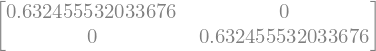

In [80]:
def K_0(alpha,J):
    #return sqrt(exp(-alpha*J)*(cos(J/2)+alpha*sin(J/2)))*Pauli(0)
    return sqrt(1-J/2)*Pauli(0)

K_0(0.01,1.2)

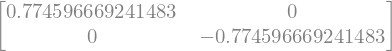

In [81]:
def K_1(alpha,J):
    return sqrt(J/2)*Pauli(3)
    return sqrt(1-exp(-alpha*J)*(cos(J/2)+alpha*sin(J/2)))*Pauli(3)

K_1(0.01,1.2)

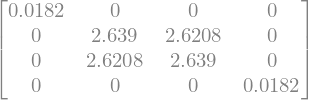

In [82]:
#ação do canal no estado |+><+| J É O TEMPO
def TP(a,b):
    return TensorProduct(a,b)
def RHO_t_NM(state,J):
    tp1 = TP(K_0(0.01,J),K_1(0.01,J))
    tp2 = TP(K_1(0.01,J),K_0(0.01,J))
    return tp1*proj(state)*tp1.T + tp2*proj(state)*tp2.T
    # return K_0(0.01,J)*proj(state)*K_0(0.01,J).T + K_1(0.01,J)*proj(state)*K_1(0.01,J).T
    return K_0(0.01,J)*proj(state)*K_0(0.01,J).T + K_1(0.01,J)*proj(state)*K_1(0.01,J).T

RHO_t_NM(werner_state(-0.8,-0.8,-0.8),0)
RHO_t_NM(werner_state(-0.8,-0.8,-0.8),1.3)


In [83]:
def get_list_p_noMarkov(list_p, type):
    lamb = 0.05
    gamma_0 = 2.8
    list_p_noMarkov = []
    if type == 'Bellomo':
        def non_markov_list_p(lamb,gamma_0,t):
            d = sqrt(2*gamma_0*lamb-lamb**2)
            result = exp(-lamb*t)*(cos(d*t/2)+(lamb/d)*sin(d*t/2))**2
            return result
    if type == 'Ana':
        def non_markov_list_p(lamb,gamma_0,t):
            result = 1-exp(-lamb*t)*(cos(t/2)+(lamb)*sin(t/2))
            return result
    for p in list_p:
        list_p_noMarkov.append(non_markov_list_p(lamb,gamma_0,p))
    return list_p_noMarkov

list_p = np.linspace(0.1,0.9,10)
#t = get_list_p_noMarkov(list_p, 'Ana')

Matrix([[0.0199998762349344, 0, 0, 0], [0, 2.89998205406549, 2.87998217783056, 0], [0, 2.87998217783056, 2.89998205406549, 0], [0, 0, 0, 0.0199998762349344]])
Matrix([[0.0199998762349344, 0, 0, 0], [0, 2.89998205406549, 2.87998217783056, 0], [0, 2.87998217783056, 2.89998205406549, 0], [0, 0, 0, 0.0199998762349344]])


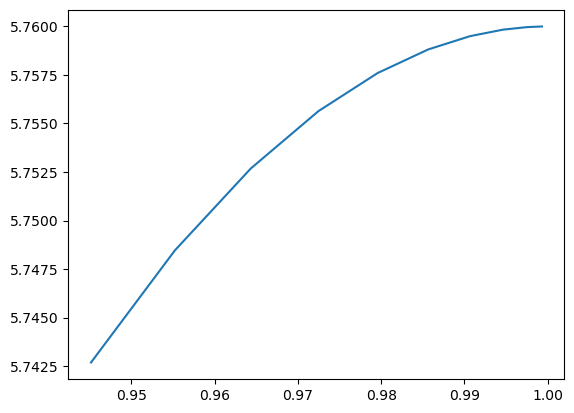

In [89]:
from sympy import MutableDenseMatrix


def changer(matrix):
    rows, cols = matrix.shape

    return MutableDenseMatrix(rows, cols, lambda i, j: float(matrix[i, j]))

t = np.linspace(0.1,0.99,10)
# t = get_list_p_noMarkov(list_p, 'Ana')
t = get_list_p_noMarkov(list_p, 'Bellomo')

state = Matrix(werner_state(-0.8,-0.8,-0.8))
#t = np.linspace(0.1,0.9,10)

print(RHO_t_NM(state, t[1]))
print(changer(RHO_t_NM(state, t[1])))
y = [coh_l1(RHO_t_NM(state, i)) for i in t]
# y = [EoF(Matrix(RHO_t_NM(state, i))) for i in t]
plt.plot(t,y)
plt.show()